In [1]:
import numpy as np
import matplotlib.pyplot as plt
import natsort, glob, h5py
from scipy.optimize import curve_fit
import scipy.signal

In [2]:
#path = r"C:/Data/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/"
path = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/'
SRS_gain = 100 # gain on the SRS bandpass filter
peak_threshold = 700 # upper bound of pedestal
breakdown = 27.4 # breakdown voltage of the SiPM
pedestal = 275 # center of noise pedestal peak

file_list = natsort.realsorted(glob.glob(path + "mca_*.h5"))[::-1]
print("Found %d files"%len(file_list))

Found 10 files


In [3]:
def gauss_fun(x, A, mu, sig):
    return A * np.exp( -(x-mu)**2/(2*sig**2) )

def lin_fun(x, m, x1):
    return m*(x-x1)

def lin_fun_const(x, m):
    return lin_fun(x,m,0)

In [4]:
def rebin_histogram(bins, counts, new_bin_size):
    """Rebin a histogram to a new bin size.
    Parameters:
        bins (np.ndarray): The bin edges of the histogram.
        counts (np.ndarray): The number of counts in each bin.
        new_bin_size (float): The size of the new bins.
    Returns:
        np.ndarray: The new bin edges.
        np.ndarray: The new bin counts.
    """
    # Find the new number of bins
    new_nbins = int((bins[-1] - bins[0]) / new_bin_size)
    # Create the new bin edges
    new_bins = np.linspace(bins[0], bins[-1], new_nbins + 1)
    # Digitize the original bins into the new bins
    digitized_bins = np.digitize(bins, new_bins)
    # Calculate the new counts
    new_counts = np.array([counts[digitized_bins == i].sum() for i in range(1, new_nbins + 1)])

    new_centers = new_bins[:-1] + np.diff(new_bins)/2
    return new_centers, new_counts

In [54]:
def find_peaks_and_fit(x_data, y_data, voltage, min_distance=20, max_peaks=5, min_thresh=10, binsize=25):
    # rebin data to make the histogram bins less small
    x, y = rebin_histogram(x_data, y_data, binsize)
    
    # Find the peaks in the spectrum using the find_peaks function from scipy.signal
    peaks_index, _ = scipy.signal.find_peaks(y, distance=min_distance)

    # Fit each peak with a Gaussian function using the curve_fit function from scipy
    peak_params = []
    peak_number = 1 # corresponds to single photoelectron
    for peak in peaks_index:
        if peak_number > max_peaks: # stopping the loop after we have reached the max number of peaks
            break

        if peak < min_thresh:
            continue

        # Initial guess for the Gaussian parameters
        amplitude_guess = y[peak]
        mean_guess = x[peak]
        standard_deviation_guess = 50
        initial_guess = [amplitude_guess, mean_guess, standard_deviation_guess]
        
        # finding the section of the data around the given peak
        if voltage < 30:
            peak_range = 150
        else:
            peak_range = 500
        if peak_number == 1: # trying to not include the pedestal for the first peak
            cut = (x < (x[peak] + peak_range)) & (x > (x[peak] - 200))
        else:
            cut = (x < (x[peak] + peak_range)) & (x > (x[peak] - peak_range))
        peak_x = x[cut]
        peak_y = y[cut]
        
        print('Peak: ', peak)
        peak_number+=1 # (goes to n*spe until it reaches max_peak)
        # Perform the curve fitting
        try:
            # trying to fit the peaks
            params, params_covariance = curve_fit(gauss_fun, peak_x, peak_y, p0=initial_guess)
            print('Guess: ', initial_guess)
            print('Params: ', params)
        except RuntimeError as r:
            # if curve fit doesn't work then we will just use the peak amplitude and center that find_peaks found
            print('fit failed')
            peak_params.append([peak, np.nan, np.nan])
            xx = np.linspace( x[peak] - 2*standard_deviation_guess, x[peak] + 2*standard_deviation_guess, 100 )
            plt.plot(xx, gauss_fun(xx, *initial_guess), 'b' )
        
        peak_params.append([peak_number, params[1], np.sqrt(params_covariance[1,1])])
    
    # Plot the original spectrum and the fitted Gaussian peaks
#         plt.plot(peak_x, peak_y, color='b')
        plt.plot(x[peak], y[peak], 'o', label='peaks')
#         plt.plot(x, gauss_fun(x, *initial_guess), color='r')
        plt.plot(x, gauss_fun(x, *params))

    plt.show()
    return np.array(peak_params), x, y

Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_33.90OV_source_0.h5
Distance:  40
Peak:  64
Guess:  [232, 1613.287786259542, 50]
Params:  [ 212.63858322 1615.30941868  140.16082038]
Peak:  124
Guess:  [88, 3114.020610687023, 50]
Params:  [  77.03647164 3152.28386297  143.3840049 ]
Peak:  184
Guess:  [47, 4614.753435114504, 50]
Params:  [  32.94610623 4672.01429924  202.46042743]
Peak:  248
Guess:  [28, 6215.535114503817, 50]
Params:  [  18.5206169  6189.02601876  234.67198181]
Peak:  309
Guess:  [15, 7741.280152671756, 50]
Params:  [  10.78173788 7723.97806213  358.76995517]


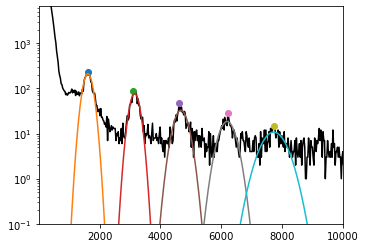

[[2.00000000e+00 1.61530942e+03 6.58382507e+00]
 [3.00000000e+00 3.15228386e+03 6.79767490e+00]
 [4.00000000e+00 4.67201430e+03 1.18289810e+01]
 [5.00000000e+00 6.18902602e+03 1.69377777e+01]
 [6.00000000e+00 7.72397806e+03 3.28613208e+01]]


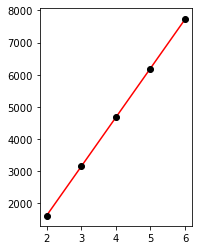

Working on file #1: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_33.40OV_source_0.h5
Distance:  35
Peak:  59
Guess:  [281, 1488.226717557252, 50]
Params:  [ 253.72627188 1496.71999766  141.89586961]
Peak:  115
Guess:  [91, 2888.9106870229007, 50]
Params:  [  81.50341489 2924.17056004  143.67273356]
Peak:  174
Guess:  [49, 4364.631297709924, 50]
Params:  [  37.38598297 4338.83275833  186.27181556]
Peak:  228
Guess:  [29, 5715.290839694657, 50]
Params:  [  21.53194304 5745.78511678  233.76676322]
Peak:  290
Guess:  [20, 7266.048091603054, 50]
Params:  [  11.21832068 7214.33693406  325.0403245 ]


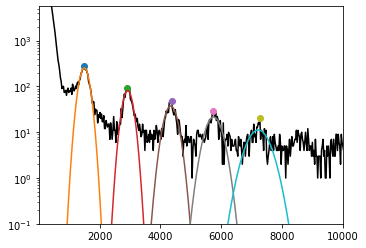

[[2.00000000e+00 1.49672000e+03 4.55682887e+00]
 [3.00000000e+00 2.92417056e+03 7.31291517e+00]
 [4.00000000e+00 4.33883276e+03 1.20460923e+01]
 [5.00000000e+00 5.74578512e+03 1.84762122e+01]
 [6.00000000e+00 7.21433693e+03 3.46519489e+01]]


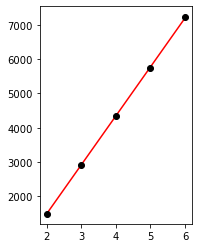

Working on file #2: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_32.90OV_source_0.h5
Distance:  30
Peak:  53
Guess:  [288, 1338.1534351145037, 50]
Params:  [ 270.59251723 1380.75037266  139.23191591]
Peak:  108
Guess:  [99, 2713.8251908396946, 50]
Params:  [  83.4108142  2699.97243558  144.04611593]
Peak:  160
Guess:  [46, 4014.460305343511, 50]
Params:  [  36.4226451  4006.2105141   184.95610045]
Peak:  212
Guess:  [27, 5315.095419847328, 50]
Params:  [  17.30556296 5309.1127001   236.73870708]
Peak:  264
Guess:  [16, 6615.730534351145, 50]
Params:  [  12.97043944 6620.04411653  227.52219233]


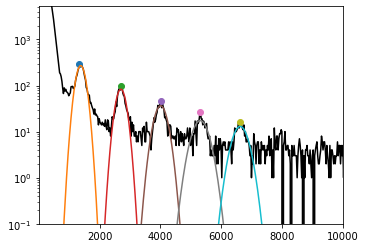

[[2.00000000e+00 1.38075037e+03 4.33418100e+00]
 [3.00000000e+00 2.69997244e+03 7.10841530e+00]
 [4.00000000e+00 4.00621051e+03 1.13688948e+01]
 [5.00000000e+00 5.30911270e+03 1.94135147e+01]
 [6.00000000e+00 6.62004412e+03 1.52017796e+01]]


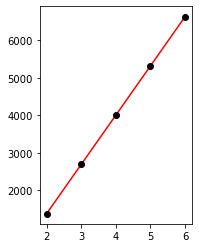

Working on file #3: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_32.40OV_source_0.h5
Distance:  25
Peak:  50
Guess:  [308, 1263.1167938931299, 50]
Params:  [ 292.22070401 1272.339706    130.58759459]
Peak:  99
Guess:  [109, 2488.7152671755725, 50]
Params:  [  94.40371144 2468.30095109  139.17036968]
Peak:  147
Guess:  [44, 3689.3015267175574, 50]
Params:  [  34.45119451 3666.7437966   197.11603571]
Peak:  195
Guess:  [29, 4889.887786259542, 50]
Params:  [  17.86195259 4879.78888115  244.58698841]
Peak:  240
Guess:  [16, 6015.437404580152, 50]
Params:  [  11.26144883 6049.36126696  326.99630805]


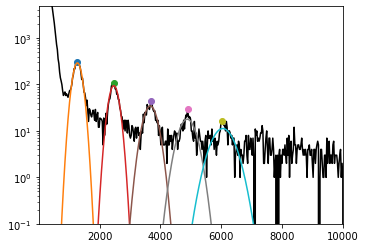

[[2.00000000e+00 1.27233971e+03 3.82016575e+00]
 [3.00000000e+00 2.46830095e+03 6.89688903e+00]
 [4.00000000e+00 3.66674380e+03 1.03591414e+01]
 [5.00000000e+00 4.87978888e+03 2.02170885e+01]
 [6.00000000e+00 6.04936127e+03 3.13154154e+01]]


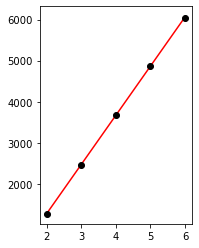

Working on file #4: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_31.90OV_source_0.h5
Distance:  25
Peak:  45
Guess:  [318, 1138.05572519084, 50]
Params:  [ 295.50559503 1165.383642    123.32421676]
Peak:  89
Guess:  [105, 2238.593129770992, 50]
Params:  [  90.59293521 2249.58907616  153.12309702]
Peak:  132
Guess:  [52, 3314.118320610687, 50]
Params:  [  39.29958974 3316.79489591  185.1952523 ]
Peak:  174
Guess:  [32, 4364.631297709924, 50]
Params:  [  19.59057165 4364.05607049  235.64785005]
Peak:  220
Guess:  [19, 5515.1931297709925, 50]
Params:  [  13.27526758 5471.40095899  238.28577696]


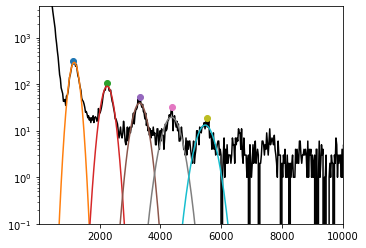

[[2.00000000e+00 1.16538364e+03 3.96853327e+00]
 [3.00000000e+00 2.24958908e+03 7.22448366e+00]
 [4.00000000e+00 3.31679490e+03 1.04405261e+01]
 [5.00000000e+00 4.36405607e+03 1.92277894e+01]
 [6.00000000e+00 5.47140096e+03 1.64240893e+01]]


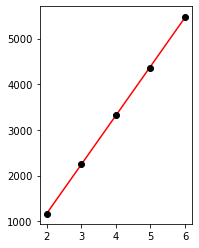

Working on file #5: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_31.40OV_source_0.h5
Distance:  25
Peak:  41
Guess:  [325, 1038.0068702290077, 50]
Params:  [ 306.42996765 1053.92364148  121.32281604]
Peak:  80
Guess:  [101, 2013.48320610687, 50]
Params:  [  90.43656233 2006.63338439  140.08398959]
Peak:  119
Guess:  [46, 2988.959541984733, 50]
Params:  [  38.16630004 2973.64840556  168.83262701]
Peak:  155
Guess:  [27, 3889.3992366412213, 50]
Params:  [  19.60068683 3927.45064629  213.4181479 ]
Peak:  199
Guess:  [18, 4989.936641221374, 50]
Params:  [  11.3225269  4936.75252562  218.92990339]


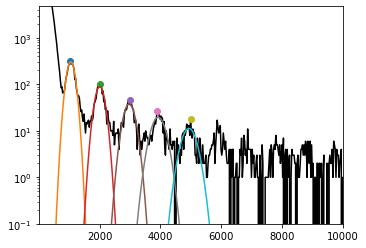

[[2.00000000e+00 1.05392364e+03 3.58093351e+00]
 [3.00000000e+00 2.00663338e+03 6.54334856e+00]
 [4.00000000e+00 2.97364841e+03 9.01272164e+00]
 [5.00000000e+00 3.92745065e+03 1.74343076e+01]
 [6.00000000e+00 4.93675253e+03 1.86240460e+01]]


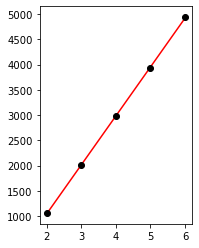

Working on file #6: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_30.90OV_source_0.h5
Distance:  20
Peak:  37
Guess:  [328, 937.9580152671756, 50]
Params:  [301.27649979 927.40609916 122.61840544]
Peak:  70
Guess:  [113, 1763.3610687022901, 50]
Params:  [  96.2972101  1774.25929151  135.81395902]
Peak:  103
Guess:  [53, 2588.7641221374047, 50]
Params:  [  36.29214999 2605.78676434  166.58481221]
Peak:  139
Guess:  [23, 3489.203816793893, 50]
Params:  [  18.74031864 3469.49887782  199.9052823 ]
Peak:  173
Guess:  [19, 4339.6190839694655, 50]
Params:  [  11.83889097 4299.08503156  198.22315336]


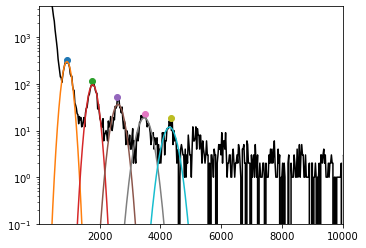

[[2.00000000e+00 9.27406099e+02 3.79360127e+00]
 [3.00000000e+00 1.77425929e+03 6.23317610e+00]
 [4.00000000e+00 2.60578676e+03 1.34650141e+01]
 [5.00000000e+00 3.46949888e+03 1.30590731e+01]
 [6.00000000e+00 4.29908503e+03 1.98473472e+01]]


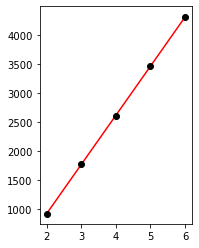

Working on file #7: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_30.40OV_source_0.h5
Distance:  15
Peak:  32
Guess:  [336, 812.8969465648855, 50]
Params:  [356.53254324 724.06758069 176.80684425]
Peak:  60
Guess:  [96, 1513.2389312977098, 50]
Params:  [  86.82462507 1531.72887091  138.58189851]
Peak:  88
Guess:  [38, 2213.5809160305344, 50]
Params:  [  27.54622726 2229.84389338  204.96828771]
Peak:  119
Guess:  [29, 2988.959541984733, 50]
Params:  [  18.05230722 2993.36735028  144.37683917]
Peak:  147
Guess:  [15, 3689.3015267175574, 50]
Params:  [  11.37254904 3695.65112814  202.99382841]


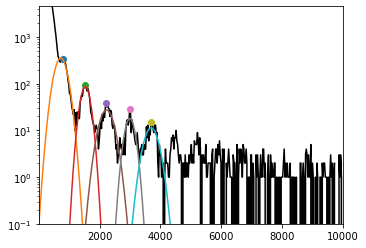

[[2.00000000e+00 7.24067581e+02 1.42427011e+01]
 [3.00000000e+00 1.53172887e+03 1.23500829e+01]
 [4.00000000e+00 2.22984389e+03 1.91396997e+01]
 [5.00000000e+00 2.99336735e+03 1.51152643e+01]
 [6.00000000e+00 3.69565113e+03 1.95176474e+01]]


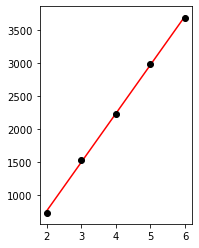

Working on file #8: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_29.90OV_source_0.h5
Distance:  15
Peak:  51
Guess:  [92, 1288.1290076335877, 50]
Params:  [  88.02368633 1287.20091189  111.19033706]
Peak:  75
Guess:  [38, 1888.42213740458, 50]
Params:  [  33.61054349 1903.33856607  132.58239273]
Peak:  99
Guess:  [27, 2488.7152671755725, 50]
Params:  [  19.2584652  2470.98014536  235.70551287]
Peak:  129
Guess:  [16, 3239.0816793893127, 50]
Params:  [  10.63393064 3073.21384289  237.28582798]
Peak:  147
Guess:  [13, 3689.3015267175574, 50]
Params:  [   9.27467966 3709.26265801  102.2112352 ]


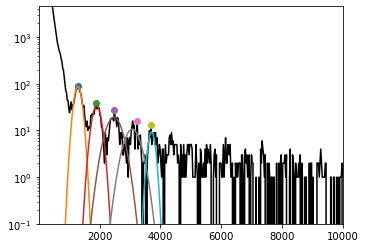

[[2.00000000e+00 1.28720091e+03 4.05794985e+00]
 [3.00000000e+00 1.90333857e+03 1.04283057e+01]
 [4.00000000e+00 2.47098015e+03 5.03593562e+01]
 [5.00000000e+00 3.07321384e+03 4.93263428e+02]
 [6.00000000e+00 3.70926266e+03 1.84620760e+01]]


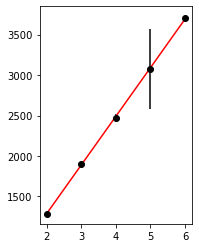

Working on file #9: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_29.40OV_source_0.h5
Distance:  15
Peak:  43
Guess:  [84, 1088.0312977099238, 50]
Params:  [  79.79532491 1028.73640655  133.45122758]
Peak:  62
Guess:  [34, 1563.2633587786258, 50]
Params:  [  28.82683069 1506.84273558  162.65982958]
Peak:  80
Guess:  [20, 2013.48320610687, 50]
Params:  [  17.71158763 2010.66904986   87.34029452]
Peak:  98
Guess:  [14, 2463.7030534351143, 50]
Params:  [   9.91990177 2512.86595635  184.75502903]
Peak:  120
Guess:  [11, 3013.9717557251906, 50]
Params:  [   7.15465632 3054.83844515  123.20705375]


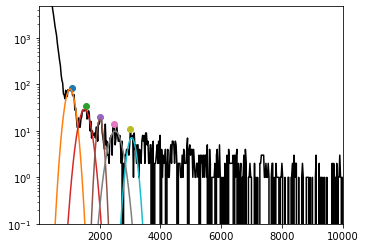

[[2.00000000e+00 1.02873641e+03 9.21302579e+00]
 [3.00000000e+00 1.50684274e+03 3.91465834e+01]
 [4.00000000e+00 2.01066905e+03 1.23804253e+01]
 [5.00000000e+00 2.51286596e+03 9.18213038e+01]
 [6.00000000e+00 3.05483845e+03 4.40416067e+01]]


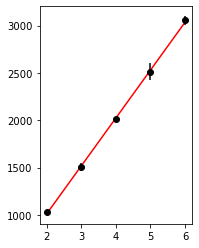

In [62]:
guess_1pe = 1100 * SRS_gain/100 - pedestal ## based on highest gain data
guess_sig = 0.1

distances = [40, 35, 30, 25, 25, 25, 20, 15, 15, 15]

gain_vs_volts = []
for i,(file, dist) in enumerate(zip(file_list, distances)): 
    print("Working on file #%d: %s"%(i,file))
    print('Distance: ', dist)

    file_parts = file.split("_")
#     print(file_parts)
    file_volts = float( file_parts[-3][:-2] ) # get voltage from filename
    try:
        file_wavelength = float(file_parts[-2]) # get wavelength from filename
    except ValueError:
        file_wavelength = file_parts[-2] # leaving tag as a string for source data



    f = h5py.File(file, 'r')  
    ch2 = f.get('ch2')
    for key in ch2.keys():
        mca_hist = np.array(ch2.get(key))
    bin_num = np.arange(len(mca_hist))
    b, c = rebin_histogram(bin_num, mca_hist, 25)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
#     plt.scatter(b, c, marker='.')
#     plt.plot(b, c, 'k')
    plt.semilogy(b, c, 'k')
    plt.ylim(0.1, np.max(mca_hist)*2)
#     plt.ylim(0.1, 350)
    plt.xlim(0.1, 10000)
    

    if(len(gain_vs_volts) > 0):
        guess_1pe = gain_vs_volts[-1][1] * (file_volts-breakdown)/(gain_vs_volts[-1][0]-breakdown) 

    pe_locs, post_bin_x, post_bin_y = find_peaks_and_fit(bin_num, mca_hist, file_volts, min_distance=dist)
#     plt.xlim(0, guess_1pe*6)


    plt.subplot(1,2,2)
    print(pe_locs)
    plt.errorbar( pe_locs[:,0], pe_locs[:,1], yerr=pe_locs[:,2], fmt='ko' )

    fpts = ~np.isnan(pe_locs[:,1])
    if(np.sum(fpts) < 3):
        continue
    gain_bp, gain_bc = curve_fit( lin_fun, pe_locs[fpts, 0], pe_locs[fpts, 1] )

    xx = pe_locs[fpts, 0]
    plt.plot( xx, lin_fun(xx, *gain_bp), 'r')

    gain_vs_volts.append( [file_volts, gain_bp[0], np.sqrt(gain_bc[0,0]), file_wavelength] )

    plt.show()

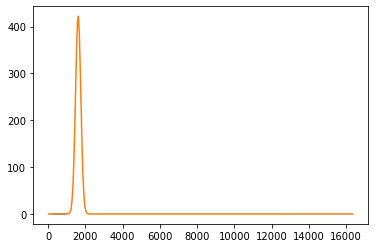

In [23]:
x_peak = post_bin_x[(post_bin_x < (442 + 500)) & (post_bin_x > (442 - 200))]
plt.plot(x_peak, gauss_fun(x_peak, 423.8980657, 1614.94424884, 141.72362772))
plt.plot(post_bin_x, gauss_fun(post_bin_x, 423.8980657, 1614.94424884, 141.72362772))

In [ ]:
##### print(gain_vs_volts) ## 2nd array - last value looks WAY off
gain_vs_volts = np.array(gain_vs_volts)
wl_to_use = gain_vs_volts[:,3] == 405
print(wl_to_use)
print(np.array(gain_vs_volts[wl_to_use,:]))

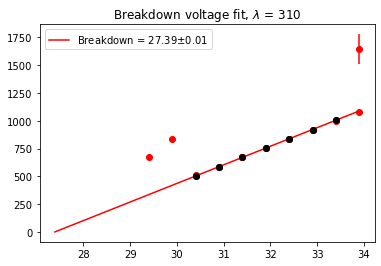

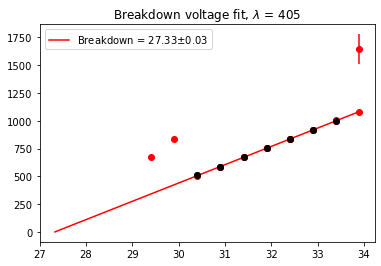

In [49]:
# change to have linear fit for both leds -- will need to use file_parts[-2][:-2] to separate them out -- will need to loop in block above

gain_vs_volts = np.array(gain_vs_volts[::-1])
wavelength = [310, 405]

voltages_to_exclude = [29.4, 29.9, 33.9]

for wl in wavelength:

    rows_to_skip = []
    for v in gain_vs_volts[:,0]:
        if(v in voltages_to_exclude):
            rows_to_skip.append(False)
        else:   
            rows_to_skip.append(True)
    rows_to_skip = np.array(rows_to_skip)
    
    rows_to_use = gain_vs_volts[:,3] == wl #select rows with the desired wavelength
    rows_to_use = rows_to_use & rows_to_skip
    bd_bp, bd_bc = curve_fit(lin_fun, gain_vs_volts[rows_to_use, 0], gain_vs_volts[rows_to_use, 1], sigma=gain_vs_volts[rows_to_use, 2])

    plt.figure()
    plt.errorbar(gain_vs_volts[:,0], gain_vs_volts[:,1], yerr=gain_vs_volts[:,2], fmt='ro')
    plt.errorbar(gain_vs_volts[rows_to_use,0], gain_vs_volts[rows_to_use,1], yerr=gain_vs_volts[rows_to_use,2], fmt='ko')
    #plt.errorbar(gain_vs_volts[~rows_to_use,0], gain_vs_volts[~rows_to_use,1], yerr=gain_vs_volts[~rows_to_use,2], fmt='ro')
    xx = np.linspace(bd_bp[1], np.max(gain_vs_volts[:,0]), 100)
    plt.plot(xx, lin_fun(xx,*bd_bp), 'r', label="Breakdown = %.2f$\pm$%.2f"%(bd_bp[1], np.sqrt(bd_bc[1,1])))
    plt.title("Breakdown voltage fit, $\lambda$ = %d"%wl)
    plt.legend()
    plt.show()

In [45]:
print(rows_to_use)

[False False False  True False  True False  True False  True False  True
 False  True False  True False False]


Found 4 files
Working on file #0: C:/Data/20230213/Step16\mca_keith_31.40OV_source_3.h5


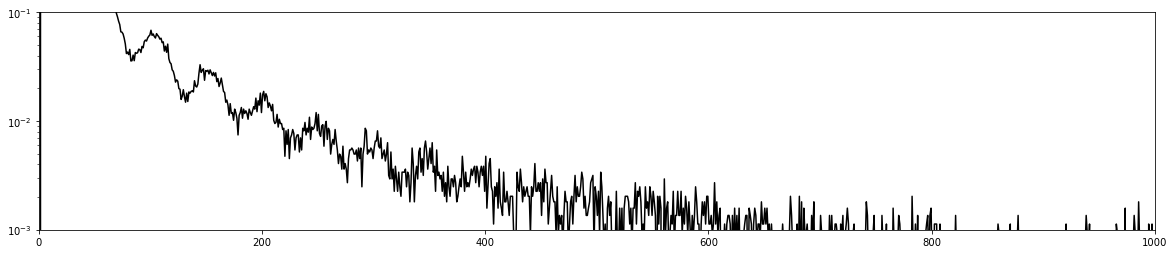

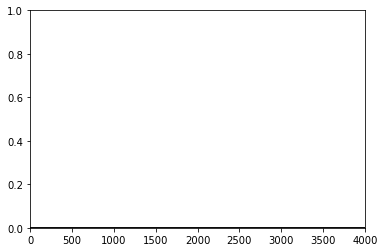

In [107]:
## Plot latest file

path = r"C:/Data/20230213/Step16/"

type_list = ['source']#, '405', '310']
col_list = ['k', 'b', 'purple']
nfiles = 1
norm_range = [3000, 12000] ## set range to normalize counts (leave empty to not use)

ref_hist = 0
fig1 = plt.figure(figsize=(20,4))
fig2 = plt.figure(figsize=(6,4))
for j,t in enumerate(type_list):
    file_list = natsort.realsorted(glob.glob(path + "*mca*%s*.h5"%t))
    print("Found %d files"%len(file_list))


    for i,file in enumerate(file_list[-nfiles:]): 
        print("Working on file #%d: %s"%(i,file))

        #file_parts = file.split("_")
        #file_volts = float( file_parts[-2][:-2] ) # get voltage from filename

        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys():
            mca_hist = np.array(ch2.get(key))
        bin_num = np.arange(len(mca_hist))

        b, c = rebin_histogram(bin_num, mca_hist, 1)

        if(len(norm_range)==2):
            gpts = (b < norm_range[1]) & (b > norm_range[0])
            norm_fac = np.sum(c[gpts])
        else:
            norm_fac = 1

        if(t == "source"):
            ref_hist = c/norm_fac
        plt.figure(fig1.number)
        plt.semilogy(b, c/norm_fac, color=col_list[j])
        plt.ylim(1e-3,1e-1)
        plt.xlim(0,1000)

        plt.figure(fig2.number)
        plt.plot(b, c/norm_fac - ref_hist, color=col_list[j])
        plt.ylim(0,1)
        plt.xlim(0,4000)

plt.show()